# **AI and the Future of Work and Learning**

### Objectives

Extract --> Transform --> load

- File 1: linkedin_job_postings.csv
- File 2: job_skills.csv
- File 3: ai_automation_risk_dataset.csv

Working with 3 files from 2 seperate datsets from kaggle:

1. 1.3M LinkedIn Jobs & Skills 2024 Dataset
2. AI Automation Risk by Job Role Dataset

Due to the large size of the original LinkedIn dataset, a subset of the data was selected and used for this project to ensure manageable processing.

Hypothesis Testing

- Hypothesis 1: Human-centred Skills and Automation Risk
- Hypothesis 2: Digital and Domain skills

Finally export cleaned, transformed data for PowerBI Dashboard.

Workflow
1. ETL (Extract → Transform → Load) - Clean Data
2. EDA: Understand the Data
3. Feature engineering: Build variables for Hypotheses
4. Hypothesis tests
5. ML prototype: A Simple Predictive Model

---

## Extract --> Transform --> Load 

Import Libraries

In [1]:
import pandas as pd # Convert to DataFrames
import numpy as np # Missing values + numeric processing 

import matplotlib.pyplot as plt # Plotting for EDA and results visualization
from scipy import stats # Statistical tests for hypothesis testing
import statsmodels.api as sm # Regression modeling and diagnostics

Read & Load the Data 

In [2]:
# Load the datsets 

job_postings = pd.read_csv("../raw_data/linkedin_job_postings-trim.csv")
role_attrs   = pd.read_csv("../raw_data/ai_automation_risk_dataset-trim.csv")

print("job_postings shape:", job_postings.shape)
print("role_attrs shape  :", role_attrs.shape)


job_postings shape: (50015, 14)
role_attrs shape  : (3000, 25)


Transform the Data 
- Clean Column Names 
- Normilisation 
- Mapping 
- Duplication 

In [3]:
# Clean and prepare text for matching job titles to job roles

def normalize_text(s):
    """Make text lowercase, remove punctuation, and clean whitespace."""
    s = str(s).lower().strip()
    s = "".join(ch if ch.isalnum() or ch.isspace() else " " for ch in s)  # remove punctuation
    s = " ".join(s.split())  # remove extra spaces
    return s

job_postings["job_link"] = job_postings["job_link"].astype(str).str.strip()
job_postings["job_title_norm"] = job_postings["job_title"].apply(normalize_text)

role_attrs["job_role"] = role_attrs["job_role"].astype(str)
role_attrs["job_role_norm"] = role_attrs["job_role"].apply(normalize_text)


In [4]:
# Map each job title to the closest job role
# if exact match exists, use it
# otherwise, if the role text appears inside the job title (substring match), use the longest match

# dictionary: normalized_role -> original_role
role_map = dict(zip(role_attrs["job_role_norm"], role_attrs["job_role"]))

def map_role(title_norm):
    # exact match
    if title_norm in role_map:
        return role_map[title_norm]

    # substring match (role words inside title)
    matches = []
    for role_norm in role_map.keys():
        if role_norm and role_norm in title_norm:
            matches.append(role_norm)

    if len(matches) > 0:
        best = max(matches, key=len)  # longest match
        return role_map[best]

    return np.nan

job_postings["job_role_mapped"] = job_postings["job_title_norm"].apply(map_role)

match_rate = job_postings["job_role_mapped"].notna().mean()
print(f"Match rate: {match_rate:.1%}")

Match rate: 14.4%


In [5]:
# Join datasets (bring automation risk info into job postings)

df = job_postings.merge(
    role_attrs.add_prefix("role__"),
    left_on="job_role_mapped",
    right_on="role__job_role",
    how="left"
)

print("Joined df shape:", df.shape)

Joined df shape: (1125625, 42)


In [6]:
# Remove duplicate postings (keep one row per job_link)

df_posting = (
    df.sort_values("job_link")
      .drop_duplicates("job_link")
      .reset_index(drop=True)
)

print("Rows after dedupe:", len(df_posting))
print("Unique job_link  :", df_posting["job_link"].nunique())

Rows after dedupe: 50015
Unique job_link  : 50015


## Feature Engineering 

In [7]:
# Convert relevant columns to numeric 
numeric_cols = {
    "automation_risk_score": "role__automation_risk_score",
    "job_growth_rate": "role__job_growth_rate",
    "task_repetition_level": "role__task_repetition_level",
    "domain_level": "role__domain_specific_knowledge_level",
    "ai_dependency": "role__ai_dependency_current",
}

for new_col, old_col in numeric_cols.items():
    df_posting[new_col] = pd.to_numeric(df_posting[old_col], errors="coerce")

In [8]:
# Build Human-Centred Skills Index

human_cols = [
    "role__communication_requirement",
    "role__social_interaction_level",
    "role__team_collaboration_level",
    "role__creativity_requirement"
]

# convert to numeric first
for c in human_cols:
    df_posting[c] = pd.to_numeric(df_posting[c], errors="coerce")

def minmax_scale(series):
    """Scale a numeric pandas Series to 0–1."""
    mn = series.min()
    mx = series.max()
    if pd.isna(mn) or pd.isna(mx) or mn == mx:
        return pd.Series([np.nan] * len(series), index=series.index)
    return (series - mn) / (mx - mn)

# scaled versions
for c in human_cols:
    df_posting[c + "_scaled"] = minmax_scale(df_posting[c])

# average of scaled columns
scaled_cols = [c + "_scaled" for c in human_cols]
df_posting["human_centred_index"] = df_posting[scaled_cols].mean(axis=1)

## Exploratory Data Analysis

Distribution

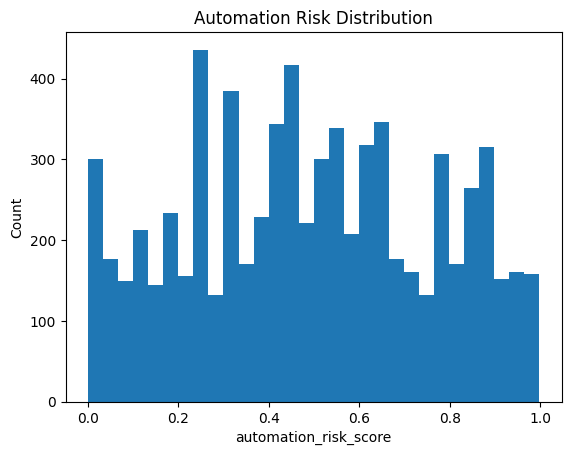

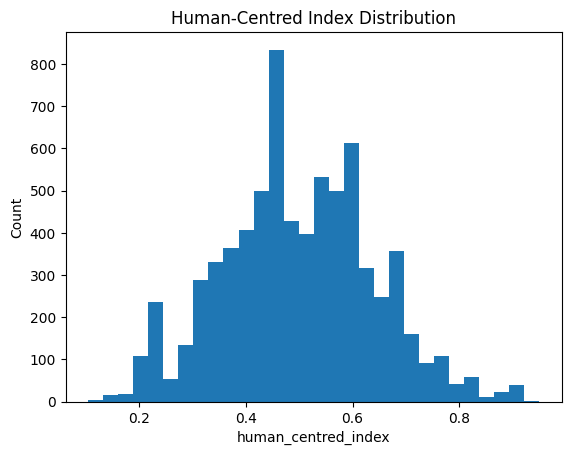

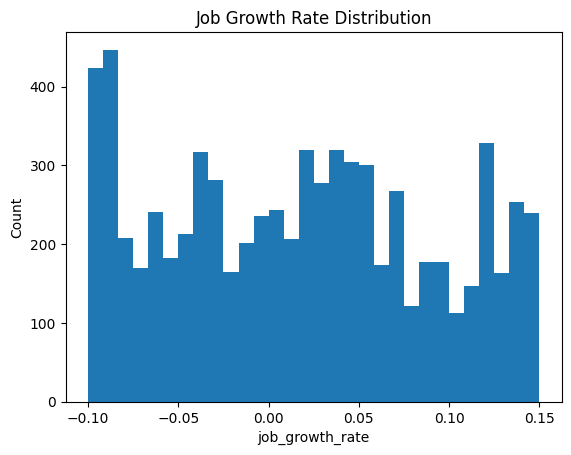

In [9]:

def plot_hist(series, title, xlabel):
    series = series.dropna()
    plt.figure()
    plt.hist(series, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

plot_hist(df_posting["automation_risk_score"], "Automation Risk Distribution", "automation_risk_score")
plot_hist(df_posting["human_centred_index"], "Human-Centred Index Distribution", "human_centred_index")
plot_hist(df_posting["job_growth_rate"], "Job Growth Rate Distribution", "job_growth_rate")



Descriptive Statistics
- count
- mean
- std
- min
- 25%, 50%, 75%
- max

In [10]:
desc_cols = [
    "automation_risk_score",
    "human_centred_index",
    "task_repetition_level",
    "job_growth_rate",
    "domain_level",
    "ai_dependency"
]

df_posting[desc_cols].describe()

,automation_risk_score,human_centred_index,task_repetition_level,job_growth_rate,domain_level,ai_dependency
count,7215.000000,7215.000000,7215.000000,7215.000000,7215.000000,7215.000000
mean,0.491497,0.498504,0.476735,0.016578,0.507492,0.495440
std,0.268652,0.141405,0.279507,0.073386,0.269642,0.285967
min,0.000739,0.104962,0.001204,-0.099897,0.000129,0.001560
25%,0.263281,0.407729,0.233395,-0.045716,0.284090,0.242065
50%,0.486839,0.492405,0.453933,0.017581,0.524114,0.490061
75%,0.700187,0.588832,0.688285,0.071948,0.716658,0.750867
max,0.997805,0.949171,0.998845,0.149902,0.999862,0.999107


## Hypothesis Testing 

Hypothesis 1:

Jobs that require more human-centred skills (communication, teamwork, social interaction and creativity) are less likely to be automated.


H1a: More human-centred skills -> LOWER automation risk

                              OLS Regression Results                             
Dep. Variable:     automation_risk_score   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     29.77
Date:                   Fri, 13 Feb 2026   Prob (F-statistic):           5.02e-08
Time:                           13:47:35   Log-Likelihood:                -739.33
No. Observations:                   7215   AIC:                             1483.
Df Residuals:                       7213   BIC:                             1496.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

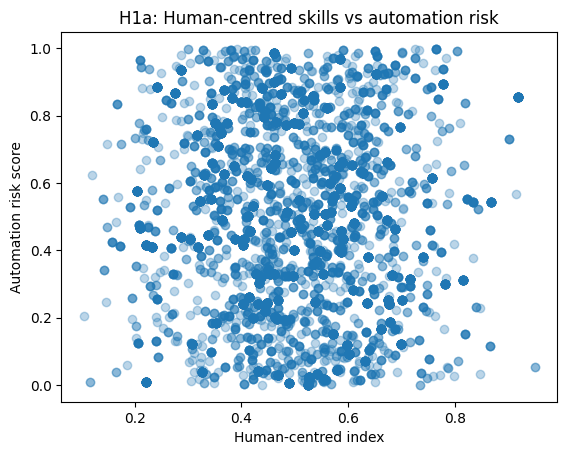

In [11]:
# Regression: risk ~ human_index
h1a = df_posting.dropna(subset=["automation_risk_score", "human_centred_index"]).copy()

X = sm.add_constant(h1a["human_centred_index"])   # adds intercept
y = h1a["automation_risk_score"]

model_h1a = sm.OLS(y, X).fit()
print(model_h1a.summary())

# Visual
plt.figure()
plt.scatter(h1a["human_centred_index"], h1a["automation_risk_score"], alpha=0.3)
plt.xlabel("Human-centred index")
plt.ylabel("Automation risk score")
plt.title("H1a: Human-centred skills vs automation risk")
plt.show()

### Results

- **human_centred_index coefficient:** −0.1218  
- **R-squared:** 0.004

### Interpretation

The negative coefficient indicates that jobs requiring higher levels of human-centred skills tend to have a slightly lower risk of automation.

Although **H1a is statistically supported**, the effect size is very small, as reflected by the low R-squared value.  
This weak effect may be partly due to the limited dataset used for the analysis, since the original dataset was reduced from approximately 1,000,000 observations to 50,000 during data trimming.

--


H1b: Repetitive tasks → HIGHER automation risk

                              OLS Regression Results                             
Dep. Variable:     automation_risk_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                   0.04758
Date:                   Fri, 13 Feb 2026   Prob (F-statistic):              0.827
Time:                           13:47:40   Log-Likelihood:                -754.17
No. Observations:                   7215   AIC:                             1512.
Df Residuals:                       7213   BIC:                             1526.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


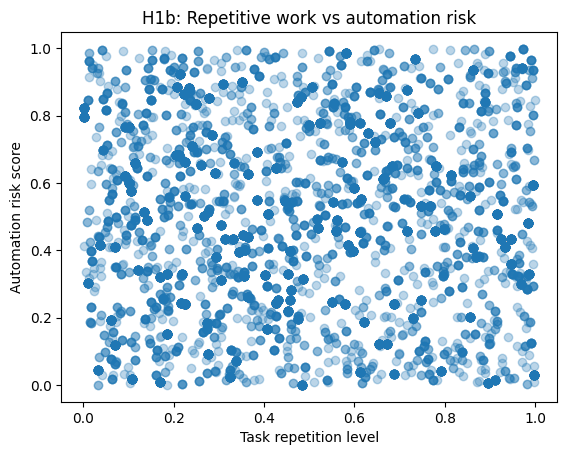

In [12]:
# Regression: risk ~ repetition

h1b = df_posting.dropna(subset=["automation_risk_score", "task_repetition_level"]).copy()

X = sm.add_constant(h1b["task_repetition_level"])
y = h1b["automation_risk_score"]

model_h1b = sm.OLS(y, X).fit()
print(model_h1b.summary())

# Visual
plt.figure()
plt.scatter(h1b["task_repetition_level"], h1b["automation_risk_score"], alpha=0.3)
plt.xlabel("Task repetition level")
plt.ylabel("Automation risk score")
plt.title("H1b: Repetitive work vs automation risk")
plt.show()


### Results 

- **task_repetition_level coefficient:** 0.0025  
- **p-value:** 0.827

### Interpretation

The coefficient is close to zero and the p-value is very large, indicating no statistically significant relationship between task repetition and automation risk.

Therefore, **H1b is not supported**.  
In this dataset, task repetition level does not significantly predict automation risk.

--

Hypothesis 2:

Job roles that combine digital or AI skills with domain knowledge (such as healthcare, business, education or engineering) are growing faster than roles that require only technical skills or only non-technical skills.

In [13]:
# role-level analysis: group roles by domain knowledge and AI dependency, then compare automation risk and growth
role_level = (
    df_posting
      .dropna(subset=["job_role_mapped", "domain_level", "ai_dependency"])
      .groupby("job_role_mapped", as_index=False)
      .agg(
          domain_level=("domain_level", "first"),
          ai_dependency=("ai_dependency", "first"),
          automation_risk_score=("automation_risk_score", "first"),
          job_growth_rate=("job_growth_rate", "first")
      )
)

domain_thr = role_level["domain_level"].median()
ai_thr     = role_level["ai_dependency"].median()

role_level["high_domain"] = role_level["domain_level"] >= domain_thr
role_level["high_ai"]     = role_level["ai_dependency"] >= ai_thr

def assign_group(row):
    if row["high_ai"] and (not row["high_domain"]):
        return "Technical-only"
    if row["high_ai"] and row["high_domain"]:
        return "Tech+Domain"
    return np.nan

role_level["skill_group"] = role_level.apply(assign_group, axis=1)
role_2g = role_level.dropna(subset=["skill_group"]).copy()

print(role_2g["skill_group"].value_counts())

# Helper: pretty p-values
def format_p(p):
    if p < 0.001:
        return "<0.001"
    return f"{p:.3f}"


skill_group
Technical-only    6
Tech+Domain       4
Name: count, dtype: int64


H2a: Tech+Domain has LOWER automation risk than Technical-only

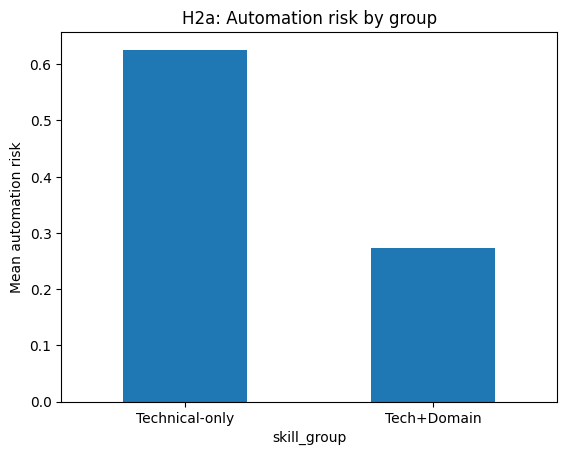

H2a results
Mean risk Tech+Domain   : 0.2730926636130051
Mean risk Technical-only: 0.6260818054866729
t = -2.237, one-sided p = 0.036


In [14]:
h2a = role_2g.dropna(subset=["automation_risk_score"]).copy()

risk_td = h2a.loc[h2a["skill_group"] == "Tech+Domain", "automation_risk_score"].values
risk_to = h2a.loc[h2a["skill_group"] == "Technical-only", "automation_risk_score"].values

# bar chart of means
means = h2a.groupby("skill_group")["automation_risk_score"].mean().reindex(["Technical-only", "Tech+Domain"])
plt.figure()
means.plot(kind="bar")
plt.ylabel("Mean automation risk")
plt.title("H2a: Automation risk by group")
plt.xticks(rotation=0)
plt.show()

# t-test (Welch)
t_stat, p_two = stats.ttest_ind(risk_td, risk_to, equal_var=False)

# one-sided p-value (Tech+Domain < Technical-only)
if np.nanmean(risk_td) < np.nanmean(risk_to):
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)

print("H2a results")
print("Mean risk Tech+Domain   :", np.nanmean(risk_td))
print("Mean risk Technical-only:", np.nanmean(risk_to))
print(f"t = {t_stat:.3f}, one-sided p = {format_p(p_one)}")


### Results 

- **Mean automation risk (Tech + Domain):** 0.273  
- **Mean automation risk (Technical-only):** 0.626  
- **t-statistic:** −2.237  
- **One-sided p-value:** 0.036  

### Interpretation

Roles that combine technical and domain skills have a substantially lower mean automation risk than technical-only roles.  
The one-sided p-value is below 0.05, indicating that this difference is statistically significant.

Therefore, **H2a is supported**.

--

H2b: Tech+Domain has HIGHER growth than Technical-only

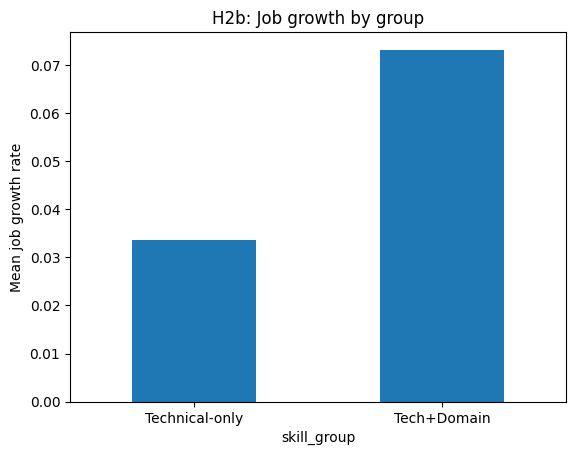

H2b results
Mean growth Tech+Domain   : 0.07321859037002573
Mean growth Technical-only: 0.033649532560767755
t = 0.581, one-sided p = 0.292


In [15]:
h2b = role_2g.dropna(subset=["job_growth_rate"]).copy()

growth_td = h2b.loc[h2b["skill_group"] == "Tech+Domain", "job_growth_rate"].values
growth_to = h2b.loc[h2b["skill_group"] == "Technical-only", "job_growth_rate"].values

means_g = h2b.groupby("skill_group")["job_growth_rate"].mean().reindex(["Technical-only", "Tech+Domain"])
plt.figure()
means_g.plot(kind="bar")
plt.ylabel("Mean job growth rate")
plt.title("H2b: Job growth by group")
plt.xticks(rotation=0)
plt.show()

t_stat, p_two = stats.ttest_ind(growth_td, growth_to, equal_var=False)

# one-sided p-value (Tech+Domain > Technical-only)
if np.nanmean(growth_td) > np.nanmean(growth_to):
    p_one = p_two / 2
else:
    p_one = 1 - (p_two / 2)

print("H2b results")
print("Mean growth Tech+Domain   :", np.nanmean(growth_td))
print("Mean growth Technical-only:", np.nanmean(growth_to))
print(f"t = {t_stat:.3f}, one-sided p = {format_p(p_one)}")

### Results 

- **Mean job growth (Tech + Domain):** 0.073  
- **Mean job growth (Technical-only):** 0.034  
- **t-statistic:** 0.581  
- **One-sided p-value:** 0.292  

### Interpretation

Although Tech + Domain roles show a higher average job growth rate than technical-only roles, the difference is **not statistically significant** (p = 0.292).

--

ML Prototype (Predictive Demo)

ML results
R^2 : 0.01
RMSE: 0.266


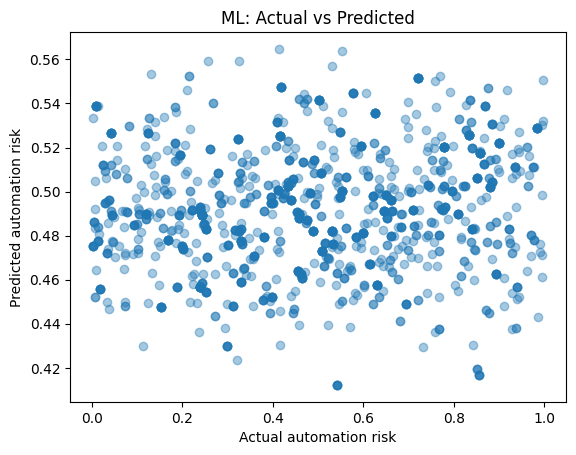

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# prepare dataset
ml_df = df_posting.dropna(subset=["automation_risk_score", "human_centred_index", "domain_level", "ai_dependency"]).copy()

X = ml_df[["human_centred_index", "domain_level", "ai_dependency"]]
y = ml_df["automation_risk_score"]

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit + predict
model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print("ML results")
print("R^2 :", round(r2, 3))
print("RMSE:", round(rmse, 3))

# Visual Actual vs Predicted
plt.figure()
plt.scatter(y_test, pred, alpha=0.4)
plt.xlabel("Actual automation risk")
plt.ylabel("Predicted automation risk")
plt.title("ML: Actual vs Predicted")
plt.show()

### Results 

- **R²:** 0.01  
- **RMSE:** 0.266  

### Interpretation

The model explains approximately 1% of the variance in automation risk, indicating very limited predictive power.  



--

Export Dashboard File 

In [17]:
import os

processed_dir = "../processed"
os.makedirs(processed_dir, exist_ok=True)

export_cols = [
    "job_link",
    "job_title",
    "job_role_mapped",
    "human_centred_index",
    "task_repetition_level",
    "automation_risk_score",
    "job_growth_rate",
    "domain_level",
    "ai_dependency"
]

export_cols = [c for c in export_cols if c in df_posting.columns]
powerbi_df = df_posting[export_cols].copy()

# ensure numeric where needed
num_cols = [
    "human_centred_index",
    "task_repetition_level",
    "automation_risk_score",
    "job_growth_rate",
    "domain_level",
    "ai_dependency"
]
for c in num_cols:
    if c in powerbi_df.columns:
        powerbi_df[c] = pd.to_numeric(powerbi_df[c], errors="coerce")

output_path = os.path.join(processed_dir, "powerbi_dashboard.csv")
powerbi_df.to_csv(output_path, index=False, encoding="utf-8")

print("Exported:", output_path)
print("Rows:", len(powerbi_df))

Exported: ../processed\powerbi_dashboard.csv
Rows: 50015
